<a href="https://colab.research.google.com/github/mbaroja/TFM/blob/code/AffinityPropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Affinity Propagation clustering**

Matriz de responsabilidad: importancia de cada punto de datos

Matriz de disponibilidad: cantidad de vecinos de cada punto

Matriz de similitud: cuanto más cercanos más similares

Ejemplares: puntos con mayor responsabilidad y disponiblidad

### Hiperparámetros
Este algoritmo no requiere determinar el número de clústeres antes de su ejecución, siendo el propio algoritmo el que encuentra el nº óptimo.

*   **damping**: factor de amortiguación que evita oscilaciones numéricas al actualizar mensajes. Rango [0.5, 1.0) a mayor damping, menos clusters
*   **affinity**: distandia euclídea (por defecto) o precalculada
*   **converge_iter**: nº de iteraciones sin cambiar el nº de clusters estimados antes de converger
*   **preference**: (none por defecto == la media de la matriz de similitud) basado en la matriz de responsablidad y disponibilidad. Recomendable muy baja, asociado al nº de clusters controla cuántos ejemplares se utilizan.
*   **max_iter**: nº máximo de iteraciones

# **Librerías**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AffinityPropagation
from sklearn.decomposition import PCA
from sklearn import metrics

# **Datos**
Trabajaremos con 3 ficheros previamente anonimizados y preprocesados (eliminación de filas con todos los valores nulos y relleno de vacíos según los criterios establecidos en el EDA https://github.com/mbaroja/TFM/blob/code/EDA.ipynb):

*   **df_without_avg**: Fichero base, sin medias: 133 x 86
*   **df_only_avg**: Fichero solo con medias: 133 x 29
*   **df_total**: Fichero completo: 133 x 110



In [ ]:
df_total = pd.read_csv('https://raw.githubusercontent.com/mbaroja/TFM/data/data_cleaned.csv', delimiter=';')
df_only_avg = pd.read_csv("https://raw.githubusercontent.com/mbaroja/TFM/data/data_cleaned_only_avgcolumns.csv",delimiter=";")
df_without_avg = pd.read_csv("https://raw.githubusercontent.com/mbaroja/TFM/data/data_cleaned_without_avgcolumns.csv",delimiter=";")

####**Transformación**
*Aunque el algoritmo permite trabajar con datos mixtos, númericos y categóricos y pueda ocurrir que la agrupación de una variable categórica convertida en númerica no obtenga el mismo resultado, trabajaremos con datos numéricos en todos los algoritmos de clasificación no supervisada.*

In [ ]:
def transformData (df):
  #identificar las columnas que contienen valores de texto en el conjunto de datos
  data_text = df.select_dtypes(include='object')
  # aplicar la codificación one-hot utilizando el método get_dummies de Pandas para convertir esas columnas en columnas numéricas
  data_encoded = pd.get_dummies(data_text)
  #una vez que preprocesados los datos, combinar las columnas numéricas procesadas con el resto del conjunto de datos.
  data_numeric = df.select_dtypes(exclude='object')
  data_processed = pd.concat([data_numeric, data_encoded], axis=1)
  return data_processed

# *Métodos para visualización*

> **Plot resultado: nº de clusters estimados**

In [ ]:
def plot_num_cluster (X, n_clusters_, labels, cluster_centers_indices):

  plt.close("all")
  plt.figure(1)
  plt.clf()

  colors = plt.cycler("color", plt.cm.viridis(np.linspace(0, 1, 4)))

  for k, col in zip(range(n_clusters_), colors):
      class_members = labels == k
      cluster_center = X[cluster_centers_indices[k]]
      plt.scatter(X[class_members, 0], X[class_members, 1], color=col["color"], marker=".")
      plt.scatter(cluster_center[0], cluster_center[1], s=14, color=col["color"], marker="o")
      for x in X[class_members]:
          plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], color=col["color"])

  plt.title("Estimated number of clusters: %d" % n_clusters_)
  plt.show()

> **Plot: Silhouette score según *preference***


In [ ]:
def plot_sil_pref (ap_results, pref):
  fig, ax = plt.subplots(figsize=(8,3))
  ax = sns.lineplot(ap_results, x='preference', y='sil_score', markers=True, dashes=False, hue='clusters')
  ax.set_xlabel("Preference")
  ax.set_ylabel("Silhouette score")
  ax.axvline(pref, ls="--", c="red")
  plt.grid()
  plt.show()

> **Heatmap de características**

In [ ]:
def heatMap (data_processed, labels, n_clusters_):
  # Agregar las etiquetas de clúster a los datos procesados
  data_processed['Cluster'] = labels

  # Crear el heatmap
  sns.heatmap(data_processed.T, cmap='coolwarm', cbar=False)
  plt.title('Clustered Data Heatmap n_clusters=%d' % n_clusters_)
  plt.show()

> **Gráfico de dispersión con etiquetas**

In [ ]:
def plot_dispersion_etiquetas (X, labels):

  # Aplicar PCA para reducir a 2 dimensiones
  pca = PCA(n_components=2)
  X_pca = pca.fit_transform(X)

  # X_pca[:, 0] son los valores en el eje x
  # X_pca[:, 1] son los valores en el eje y
  # labels son las etiquetas de los grupos

  # Crea el gráfico de dispersión con colores según las etiquetas
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
  # Crea una leyenda o mapa de colores
  plt.colorbar()
  # Etiqueta cada punto con el índice de la fila correspondiente
  for i, label in enumerate(labels):
      plt.annotate(i, (X_pca[i, 0], X_pca[i, 1]))
  # Muestra el gráfico
  plt.show()

> **Listar atributos por cluster**

In [ ]:
def list_atributos_porCluster (data_processed, n_clusters_, labels):
  # Aplicar PCA al conjunto de datos
  pca = PCA()
  pca.fit(data_processed)

  # Obtener las componentes principales y su varianza explicada
  components = pca.components_
  explained_variance = pca.explained_variance_ratio_

  # Obtener los índices de los atributos más importantes para cada clúster
  important_attributes = []
  for cluster in range(n_clusters_):
      cluster_indices = np.where(labels == cluster)[0]
      cluster_data = data_processed.iloc[cluster_indices]
      cluster_scores = np.mean(cluster_data.dot(components.T), axis=0)
      important_attributes.append(np.argsort(-np.abs(cluster_scores)))

  # Nombres de los campos
  column_names = data_processed.columns.tolist()

  # Imprimir los atributos más importantes por clúster
  for cluster, attributes in enumerate(important_attributes):
      print(f"Cluster {cluster+1}:")
      for attribute in attributes[:5]:  # Mostrar los 5 atributos más importantes
          attribute_name = column_names[attribute]
          attribute_mean = np.mean(data_processed.iloc[np.where(labels == cluster)[0], attribute])
          print(f"- Atributo n. {attribute+1}: {attribute_name} (Media: {attribute_mean})")

# **1. Affinity Propagation: euclídea**





### **Evaluación del modelo según la preferencia**
Para encontrar el valor del parámetro *preference* asociado al nº de clústeres estimados, lo calculamos a partir de la métrica **Coeficiente de Silhoutte** que mide la compactación y separación de los grupos. Cuanto más alto sea el coeficiente, más similares son entre sí los datos agrupados.

Ejecutamos el algoritmo con un rango *preference* entre -20000 y -200 iternado de 200 en 200.

In [ ]:
def eval_preferences(X):
  preferences = range(-20000, -200, 200)
  num_clusters = []
  sil_score = []

  for p in preferences:
    ap = AffinityPropagation(preference = p, max_iter=200, damping=0.70).fit(X)
    n_clusters_ = len(ap.cluster_centers_indices_)
    if n_clusters_ > 1:
      num_clusters.append(n_clusters_)
      sil_score.append(metrics.silhouette_score(X, ap.labels_))

  ap_results = pd.DataFrame([preferences, num_clusters, sil_score], index=['preference', 'clusters', 'sil_score']).T
  return ap_results

### **1.1 Fichero completo**

In [ ]:
#Transformar datos categóricos a númericos
data_processed = transformData(df_total)
#Crear una matriz de características (feature matrix) a partir de los datos y sus columnas
X, y = data_processed.values, data_processed.columns

In [ ]:
#prueba básica
afprop  = AffinityPropagation(preference=-50)
afprop.fit(X)
labels = afprop.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')

In [ ]:
#Obtener el valor apropiado para 'preferences' a partir del mejor coeficiente Silhoutte obtenido
ap_results = eval_preferences(X)
ap_results.sort_values(by='sil_score', ascending=False).head(5)

,preference,clusters,sil_score
38,-12400.0,2.0,0.555385
15,-17000.0,2.0,0.555385
27,-14600.0,2.0,0.555385
26,-14800.0,2.0,0.555385
25,-15000.0,2.0,0.555385


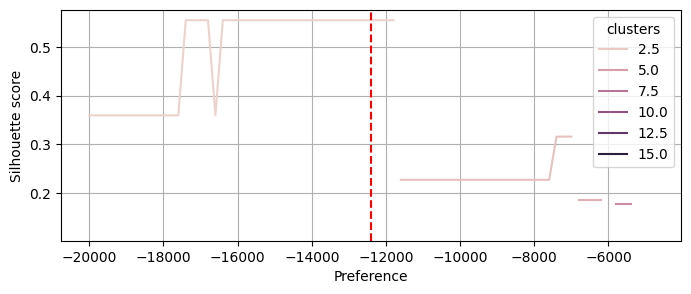

In [ ]:
#Visualizar la evolución de los valores del coeficiente Silhoutte
plot_sil_pref(ap_results, -12400)

In [ ]:
#Ejecución del algoritmo con los parámetros que obtienen un mejor coeficiente Silhoutte
ap = AffinityPropagation(damping=0.70, preference=-17000, max_iter=200)
model = ap.fit(X)
cluster_centers_indices = model.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = model.predict(X)

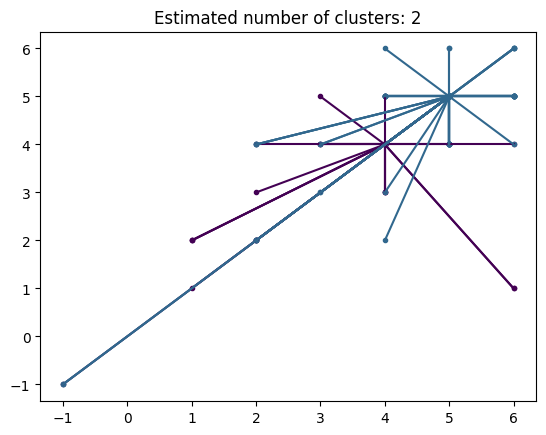

In [ ]:
#Visualizar resultado relación de atributos según el nº de clústeres estimados
plot_num_cluster (X, n_clusters_, labels, cluster_centers_indices)

In [ ]:
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

Estimated number of clusters: 2
Silhouette Coefficient: 0.543


In [ ]:
#Visualizar maña de calor por atributos
heatMap (data_processed, labels, n_clusters_)

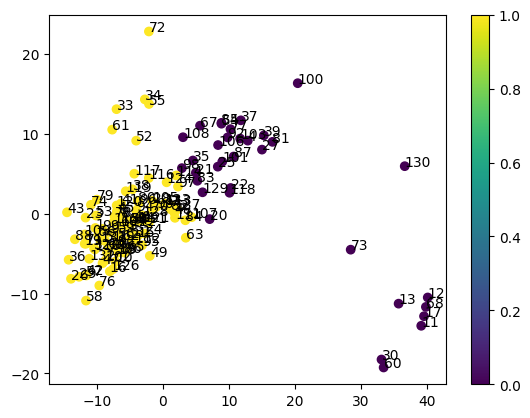

In [ ]:
#Visualizar gráfica de dispersión con la relación de atributos por clúster
plot_dispersion_etiquetas (X, labels)

In [ ]:
#Listar la relación de lso atributos más implicados para ser asociados a ese clúster
list_atributos_porCluster (data_processed, n_clusters_, labels)

Cluster 1:
- Atributo n. 1: V1 (Media: 3.4705882352941178)
- Atributo n. 4: SA1 (Media: 3.176470588235294)
- Atributo n. 3: V3 (Media: 2.735294117647059)
- Atributo n. 13: SF1 (Media: 1.6764705882352942)
- Atributo n. 14: SF2 (Media: 2.176470588235294)
Cluster 2:
- Atributo n. 1: V1 (Media: 4.525252525252525)
- Atributo n. 4: SA1 (Media: 4.626262626262626)
- Atributo n. 3: V3 (Media: 3.8686868686868685)
- Atributo n. 2: V2 (Media: 4.454545454545454)
- Atributo n. 13: SF1 (Media: 3.878787878787879)


### **1.2 Fichero solo medias**

In [ ]:
#Transformar datos categóricos a númericos
data_processed2 = transformData(df_only_avg)
#Crear una matriz de características (feature matrix) a partir de los datos y sus columnas
X2, y2 = data_processed2.values, data_processed2.columns

In [ ]:
#Obtener el valor apropiado para 'preferences' a partir del mejor coeficiente Silhoutte obtenido
ap_results2 = eval_preferences(X2)
ap_results2.sort_values(by='sil_score', ascending=False).head(5)

,preference,clusters,sil_score
4,-19200.0,2.0,0.576363
7,-18600.0,2.0,0.576363
8,-18400.0,2.0,0.576363
10,-18000.0,2.0,0.576363
0,-20000.0,2.0,0.364543


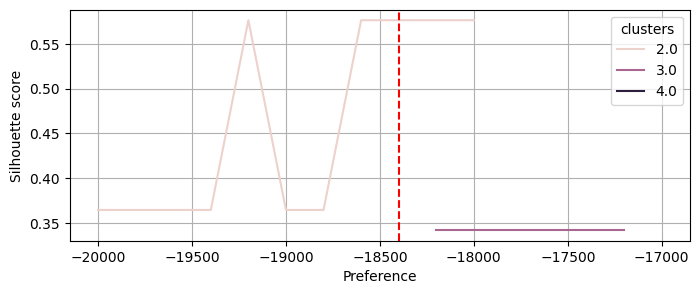

In [ ]:
#Visualizar la evolución de los valores del coeficiente Silhoutte
plot_sil_pref(ap_results2, -18400)

In [ ]:
#Ejecución del algoritmo con los parámetros que obtienen un mejor coeficiente Silhoutte
ap2 = AffinityPropagation(damping=0.70, preference=-18500, max_iter=200)
model2 = ap2.fit(X2)
cluster_centers_indices2 = model2.cluster_centers_indices_
n2_clusters_ = len(cluster_centers_indices2)
labels2 = model2.predict(X2)

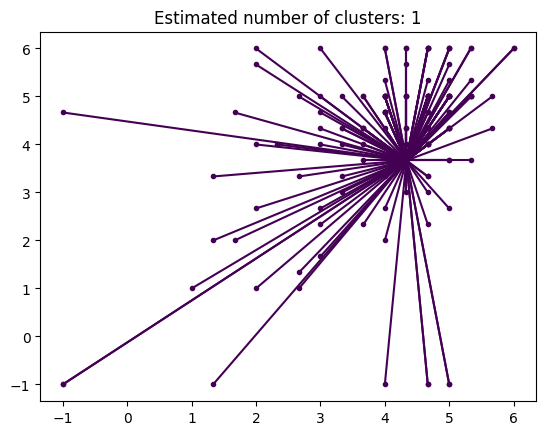

In [ ]:
#Visualizar resultado relación de atributos según el nº de clústeres estimados
plot_num_cluster (X2, n2_clusters_, labels2, cluster_centers_indices2)

In [ ]:
print('Estimated number of clusters: %d' % n2_clusters_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X2, labels2, metric='sqeuclidean'))

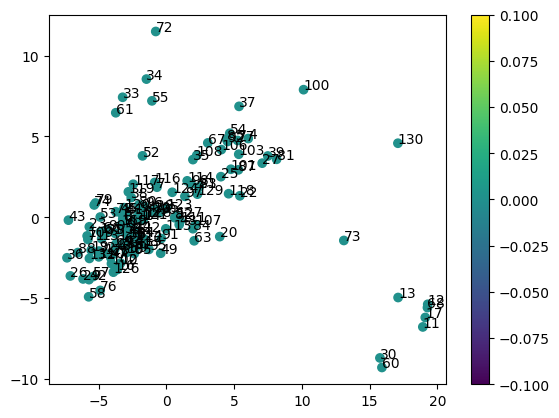

In [ ]:
#Visualizar gráfica de dispersión con la relación de atributos por clúster
plot_dispersion_etiquetas (X2, labels2)

In [ ]:
#Listar la relación de lso atributos más implicados para ser asociados a ese clúster
list_atributos_porCluster (data_processed2, n2_clusters_, labels2)

Cluster 1:
- Atributo n. 1: V_media (Media: 4.0)
- Atributo n. 4: SP_media (Media: 2.452380952380952)
- Atributo n. 2: SA_media (Media: 4.085213032581453)
- Atributo n. 3: SI_media (Media: 4.076441102756892)
- Atributo n. 11: CJ_media (Media: 2.7243107769423562)


### **1.3 Fichero sin medias**

In [ ]:
#Transformar datos categóricos a númericos
data_processed3 = transformData(df_without_avg)
#Crear una matriz de características (feature matrix) a partir de los datos y sus columnas
X3, y3 = data_processed3.values, data_processed3.columns

In [ ]:
#Obtener el valor apropiado para 'preferences' a partir del mejor coeficiente Silhoutte obtenido
ap_results3 = eval_preferences(X3)
ap_results3.sort_values(by='sil_score', ascending=False).head(5)

,preference,clusters,sil_score
31,-13800.0,2.0,0.546462
18,-16400.0,2.0,0.546462
19,-16200.0,2.0,0.546462
20,-16000.0,2.0,0.546462
21,-15800.0,2.0,0.546462


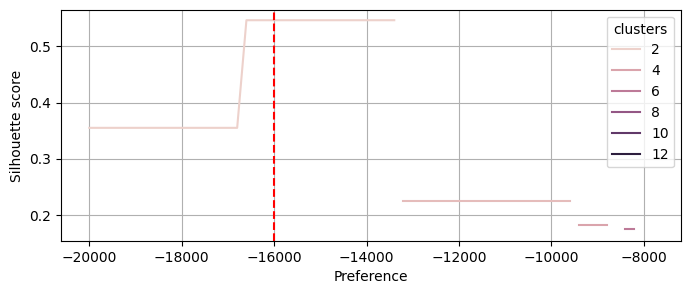

In [ ]:
#Visualizar la evolución de los valores del coeficiente Silhoutte
plot_sil_pref(ap_results3, -16000)

In [ ]:
#Ejecución del algoritmo con los parámetros que obtienen un mejor coeficiente Silhoutte
ap3 = AffinityPropagation(damping=0.70, preference=-16000, max_iter=200)
model3 = ap3.fit(X)
cluster_centers_indices3 = model3.cluster_centers_indices_
n3_clusters_ = len(cluster_centers_indices3)
labels3 = model3.predict(X)

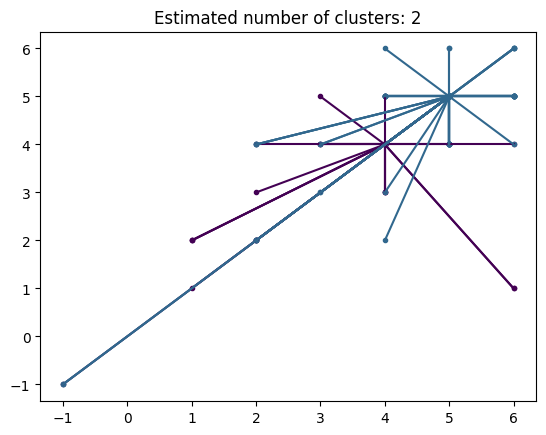

In [ ]:
#Visualizar resultado relación de atributos según el nº de clústeres estimados
plot_num_cluster (X3, n3_clusters_, labels3, cluster_centers_indices3)

In [ ]:
print('Estimated number of clusters: %d' % n3_clusters_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X3, labels3, metric='sqeuclidean'))

Estimated number of clusters: 2
Silhouette Coefficient: 0.534


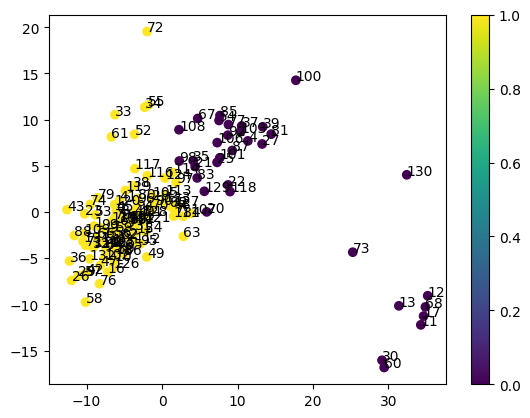

In [ ]:
#Visualizar gráfica de dispersión con la relación de atributos por clúster
plot_dispersion_etiquetas (X3, labels3)

In [ ]:
#Listar la relación de lso atributos más implicados para ser asociados a ese clúster
list_atributos_porCluster (data_processed3, n3_clusters_, labels3)

Cluster 1:
- Atributo n. 1: V1 (Media: 3.4705882352941178)
- Atributo n. 4: SA1 (Media: 3.176470588235294)
- Atributo n. 3: V3 (Media: 2.735294117647059)
- Atributo n. 13: SF1 (Media: 1.6764705882352942)
- Atributo n. 15: SF3 (Media: 1.9411764705882353)
Cluster 2:
- Atributo n. 1: V1 (Media: 4.525252525252525)
- Atributo n. 4: SA1 (Media: 4.626262626262626)
- Atributo n. 3: V3 (Media: 3.8686868686868685)
- Atributo n. 2: V2 (Media: 4.454545454545454)
- Atributo n. 13: SF1 (Media: 3.878787878787879)
